In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

data = pd.read_csv('./data/mental_health_and_technology_usage_2024.csv')

# Первичный анализ дата сета


### Посмотрим на первые 5 строк дата сета

In [2]:
data.head()

,User_ID,Age,Gender,Technology_Usage_Hours,Social_Media_Usage_Hours,Gaming_Hours,Screen_Time_Hours,Mental_Health_Status,Stress_Level,Sleep_Hours,Physical_Activity_Hours,Support_Systems_Access,Work_Environment_Impact,Online_Support_Usage
0,USER-00001,23,Female,6.57,6.00,0.68,12.36,Good,Low,8.01,6.71,No,Negative,Yes
1,USER-00002,21,Male,3.01,2.57,3.74,7.61,Poor,High,7.28,5.88,Yes,Positive,No
2,USER-00003,51,Male,3.04,6.14,1.26,3.16,Fair,High,8.04,9.81,No,Negative,No
3,USER-00004,25,Female,3.84,4.48,2.59,13.08,Excellent,Medium,5.62,5.28,Yes,Negative,Yes
4,USER-00005,53,Male,1.20,0.56,0.29,12.63,Good,Low,5.55,4.00,No,Positive,Yes


### Посмотрим на размер дата сета  и типы данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   User_ID                   10000 non-null  object 
 1   Age                       10000 non-null  int64  
 2   Gender                    10000 non-null  object 
 3   Technology_Usage_Hours    10000 non-null  float64
 4   Social_Media_Usage_Hours  10000 non-null  float64
 5   Gaming_Hours              10000 non-null  float64
 6   Screen_Time_Hours         10000 non-null  float64
 7   Mental_Health_Status      10000 non-null  object 
 8   Stress_Level              10000 non-null  object 
 9   Sleep_Hours               10000 non-null  float64
 10  Physical_Activity_Hours   10000 non-null  float64
 11  Support_Systems_Access    10000 non-null  object 
 12  Work_Environment_Impact   10000 non-null  object 
 13  Online_Support_Usage      10000 non-null  object 
dtypes: floa

### Посмотрим на статистику дата сета

In [4]:
data.describe()

,Age,Technology_Usage_Hours,Social_Media_Usage_Hours,Gaming_Hours,Screen_Time_Hours,Sleep_Hours,Physical_Activity_Hours
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,41.518600,6.474341,3.972321,2.515598,7.975765,6.500724,5.003860
std,13.920217,3.169022,2.313707,1.446748,4.042608,1.450933,2.905044
min,18.000000,1.000000,0.000000,0.000000,1.000000,4.000000,0.000000
25%,29.000000,3.760000,1.980000,1.260000,4.520000,5.260000,2.490000
50%,42.000000,6.425000,3.950000,2.520000,7.900000,6.500000,4.990000
75%,54.000000,9.212500,5.990000,3.790000,11.500000,7.760000,7.540000
max,65.000000,12.000000,8.000000,5.000000,15.000000,9.000000,10.000000


### Посмотрим на количество пропущенных значений

In [5]:
data.isnull().sum()

User_ID                     0
Age                         0
Gender                      0
Technology_Usage_Hours      0
Social_Media_Usage_Hours    0
Gaming_Hours                0
Screen_Time_Hours           0
Mental_Health_Status        0
Stress_Level                0
Sleep_Hours                 0
Physical_Activity_Hours     0
Support_Systems_Access      0
Work_Environment_Impact     0
Online_Support_Usage        0
dtype: int64

### Посмотрим на количество дубликатов

In [6]:
print(data.duplicated().sum())

0


### Посмотрим на количество уникальных значений

In [7]:
data.nunique()

User_ID                     10000
Age                            48
Gender                          3
Technology_Usage_Hours       1101
Social_Media_Usage_Hours      801
Gaming_Hours                  501
Screen_Time_Hours            1400
Mental_Health_Status            4
Stress_Level                    3
Sleep_Hours                   501
Physical_Activity_Hours      1001
Support_Systems_Access          2
Work_Environment_Impact         3
Online_Support_Usage            2
dtype: int64

In [8]:
data['Age'].unique()

array([23, 21, 51, 25, 53, 58, 63, 57, 31, 64, 40, 24, 38, 26, 55, 37, 34,
       39, 42, 27, 50, 60, 20, 29, 30, 47, 41, 44, 48, 45, 59, 62, 28, 32,
       49, 33, 18, 36, 19, 22, 35, 46, 56, 54, 61, 52, 65, 43])

### Посмотрим на распределение значений в колонке Age

In [9]:
data['Age'].value_counts()

Age
62    245
59    235
32    231
65    230
45    226
38    224
50    224
25    222
26    220
18    220
46    218
53    218
57    218
23    216
21    216
22    216
49    215
42    214
20    214
52    214
29    213
24    212
27    210
37    208
64    208
41    208
34    207
36    207
63    207
33    206
40    205
56    203
43    203
44    202
55    198
39    197
35    197
30    196
58    196
54    194
51    191
28    190
61    187
31    186
60    186
48    186
47    183
19    178
Name: count, dtype: int64

In [10]:
data['Age'].describe()

count    10000.000000
mean        41.518600
std         13.920217
min         18.000000
25%         29.000000
50%         42.000000
75%         54.000000
max         65.000000
Name: Age, dtype: float64

# Анализ данных

### Посмотрим на распределение признаков


Анализ распределения для признака: Age


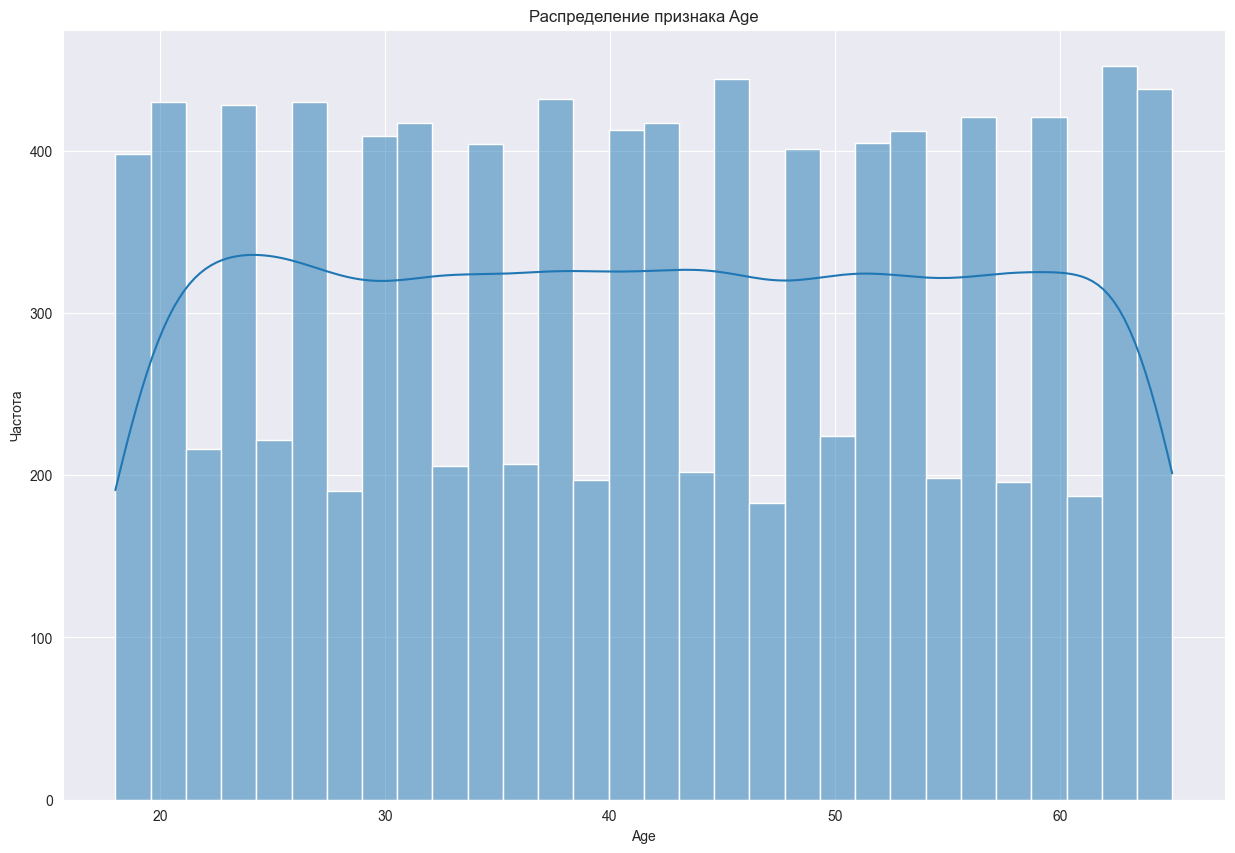

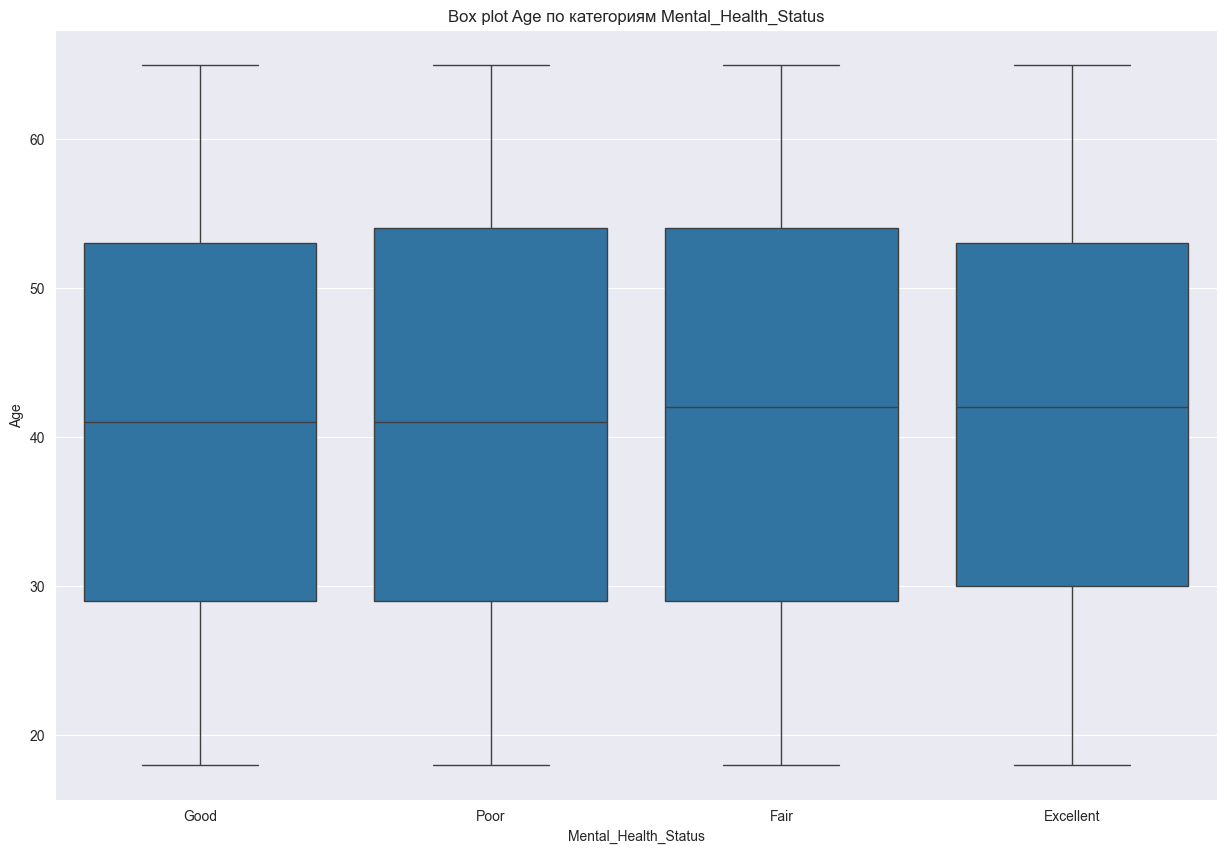

Базовая статистика для Age:
count    10000.000000
mean        41.518600
std         13.920217
min         18.000000
25%         29.000000
50%         42.000000
75%         54.000000
max         65.000000
Name: Age, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Gender


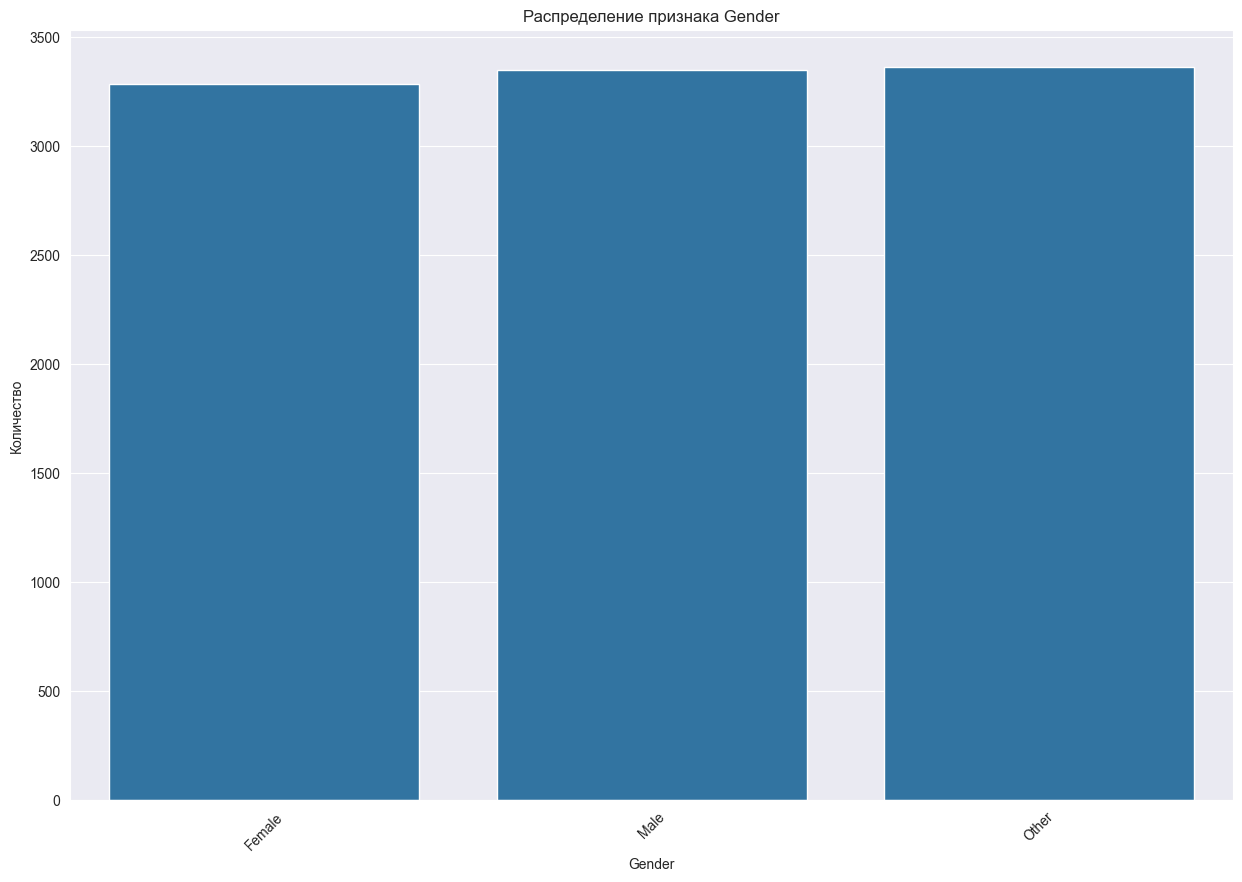

Базовая статистика для Gender:
count     10000
unique        3
top       Other
freq       3364
Name: Gender, dtype: object

--------------------------------------------------

Анализ распределения для признака: Technology_Usage_Hours


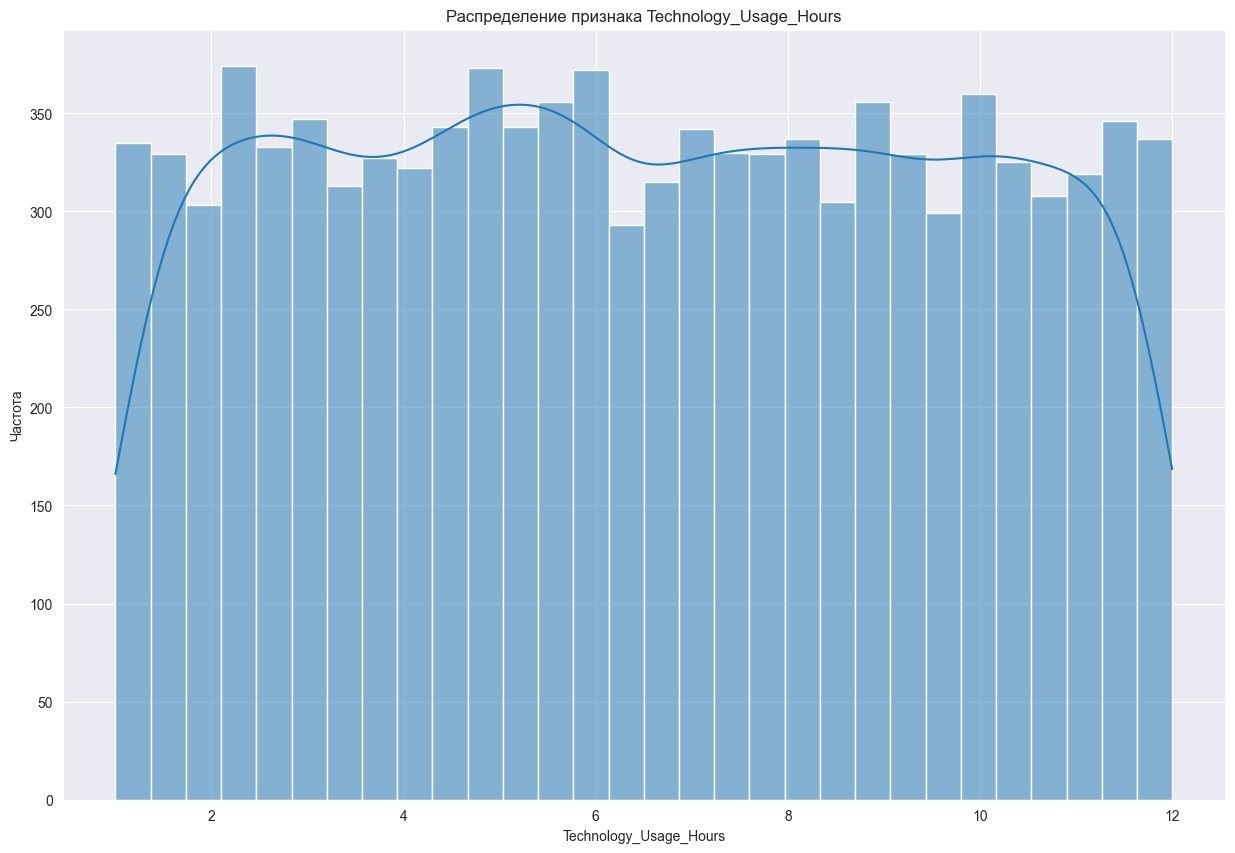

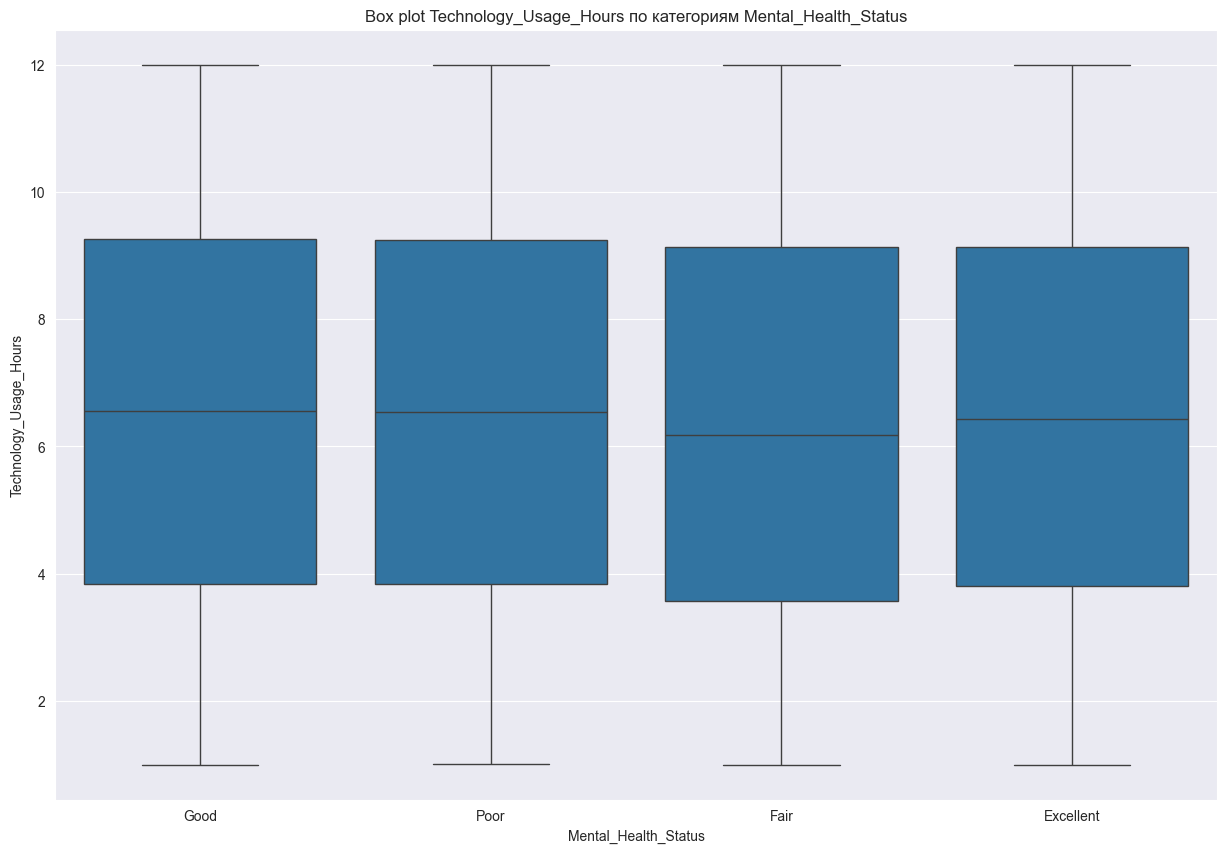

Базовая статистика для Technology_Usage_Hours:
count    10000.000000
mean         6.474341
std          3.169022
min          1.000000
25%          3.760000
50%          6.425000
75%          9.212500
max         12.000000
Name: Technology_Usage_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Social_Media_Usage_Hours


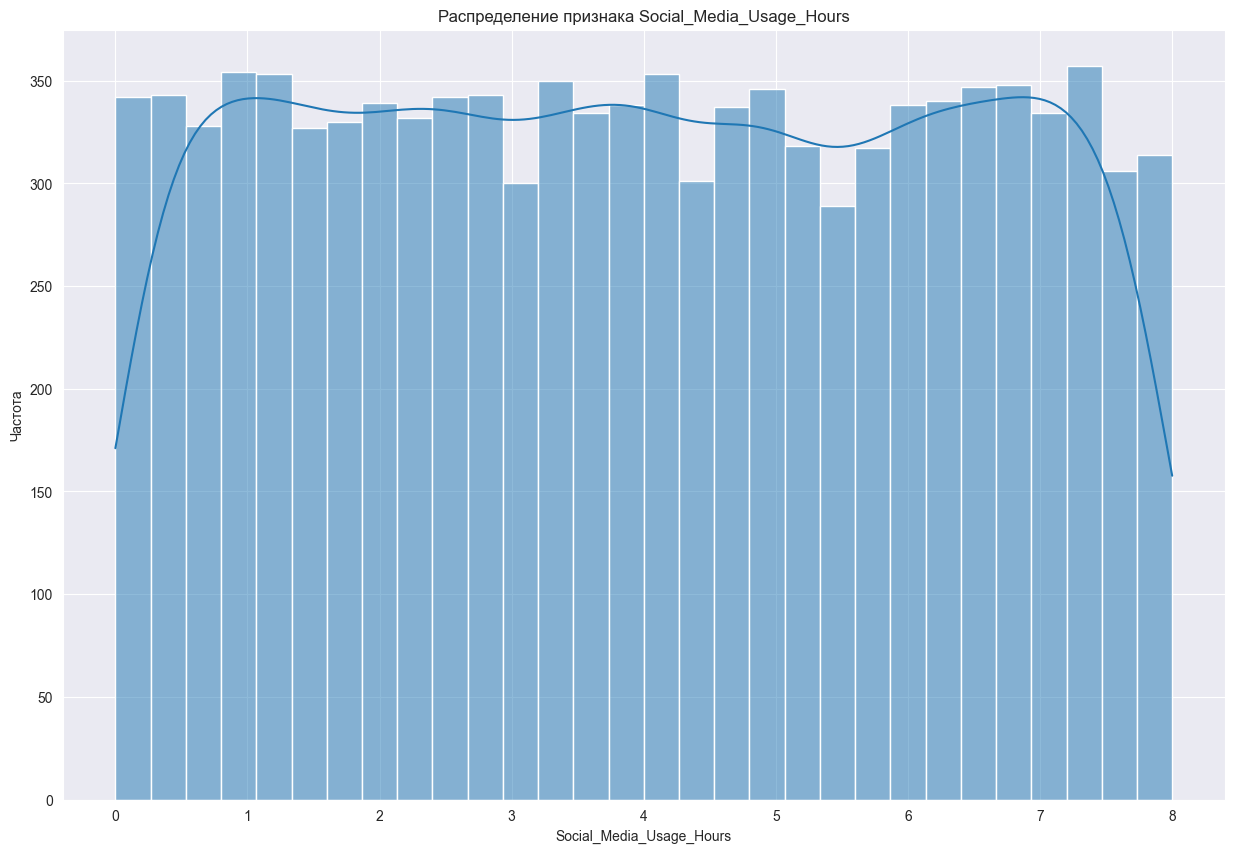

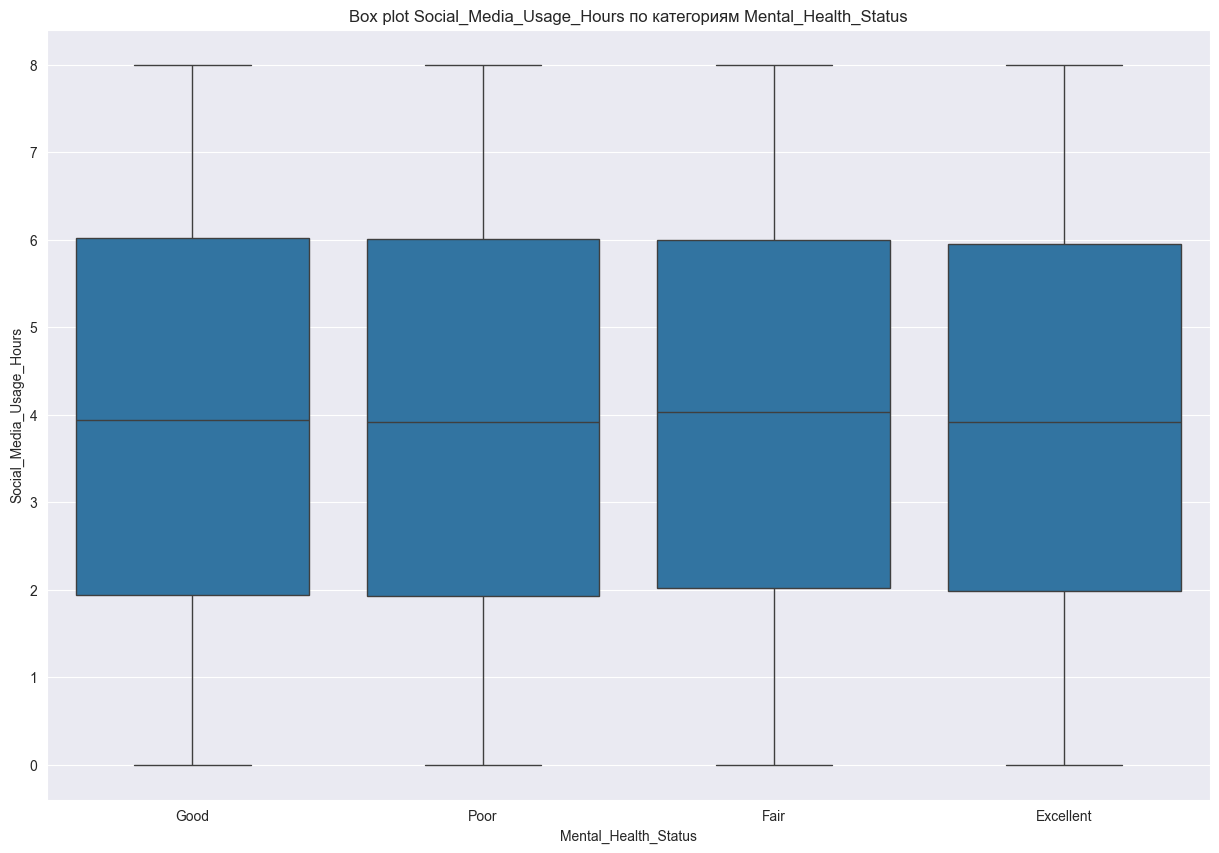

Базовая статистика для Social_Media_Usage_Hours:
count    10000.000000
mean         3.972321
std          2.313707
min          0.000000
25%          1.980000
50%          3.950000
75%          5.990000
max          8.000000
Name: Social_Media_Usage_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Gaming_Hours


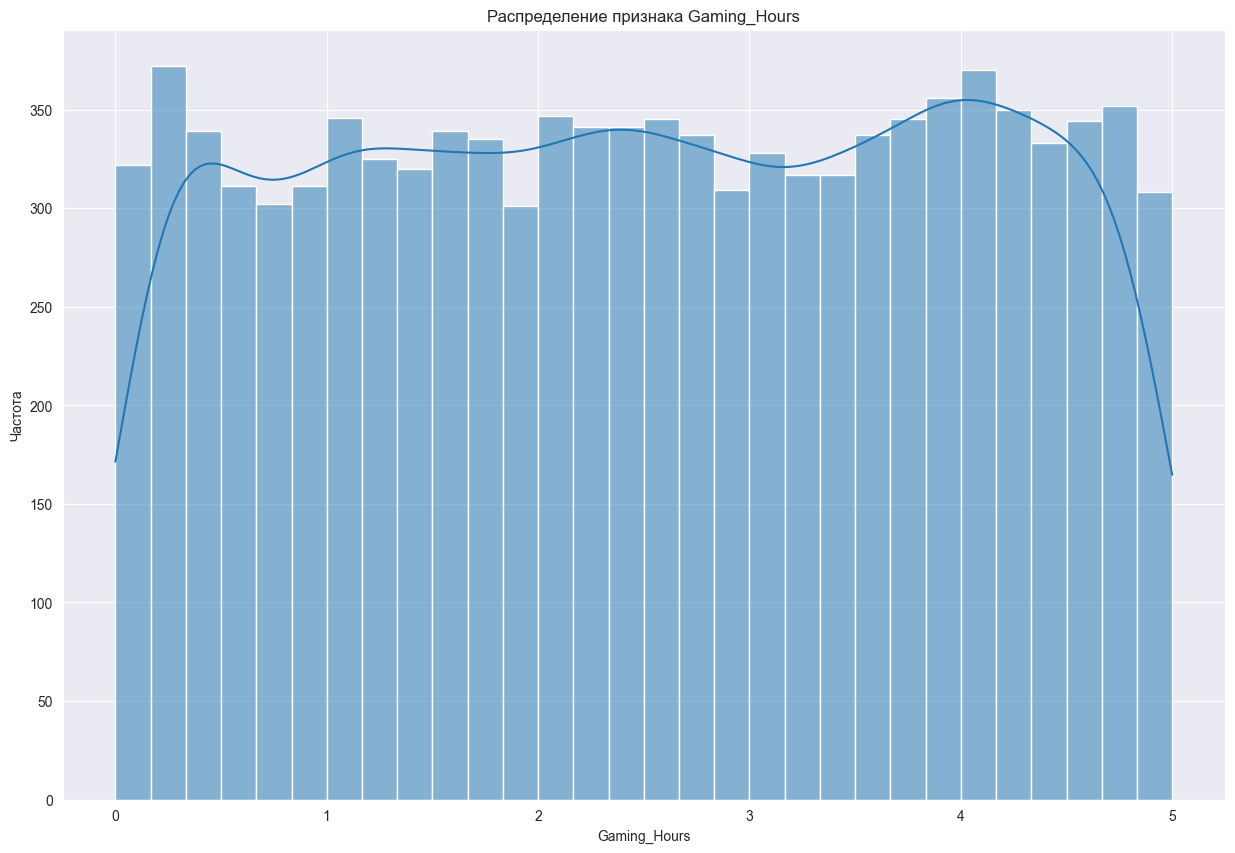

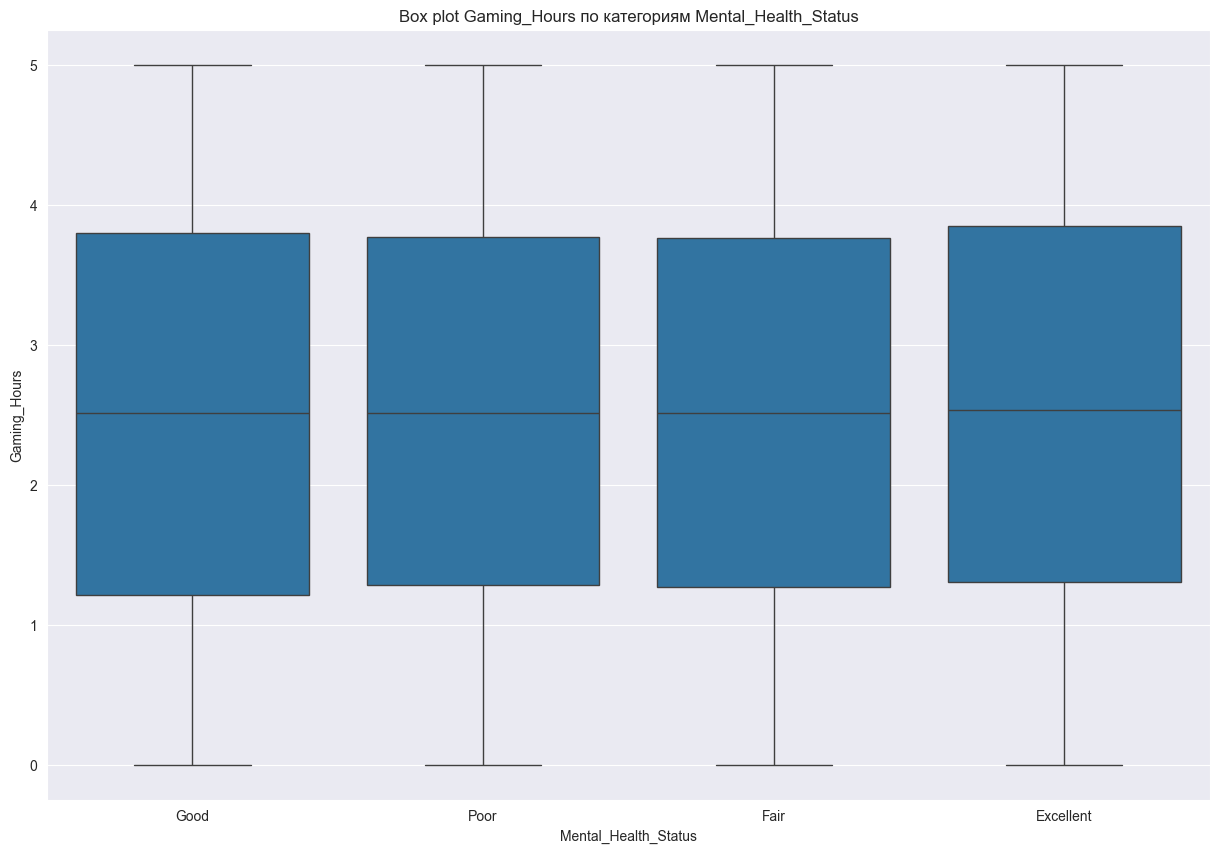

Базовая статистика для Gaming_Hours:
count    10000.000000
mean         2.515598
std          1.446748
min          0.000000
25%          1.260000
50%          2.520000
75%          3.790000
max          5.000000
Name: Gaming_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Screen_Time_Hours


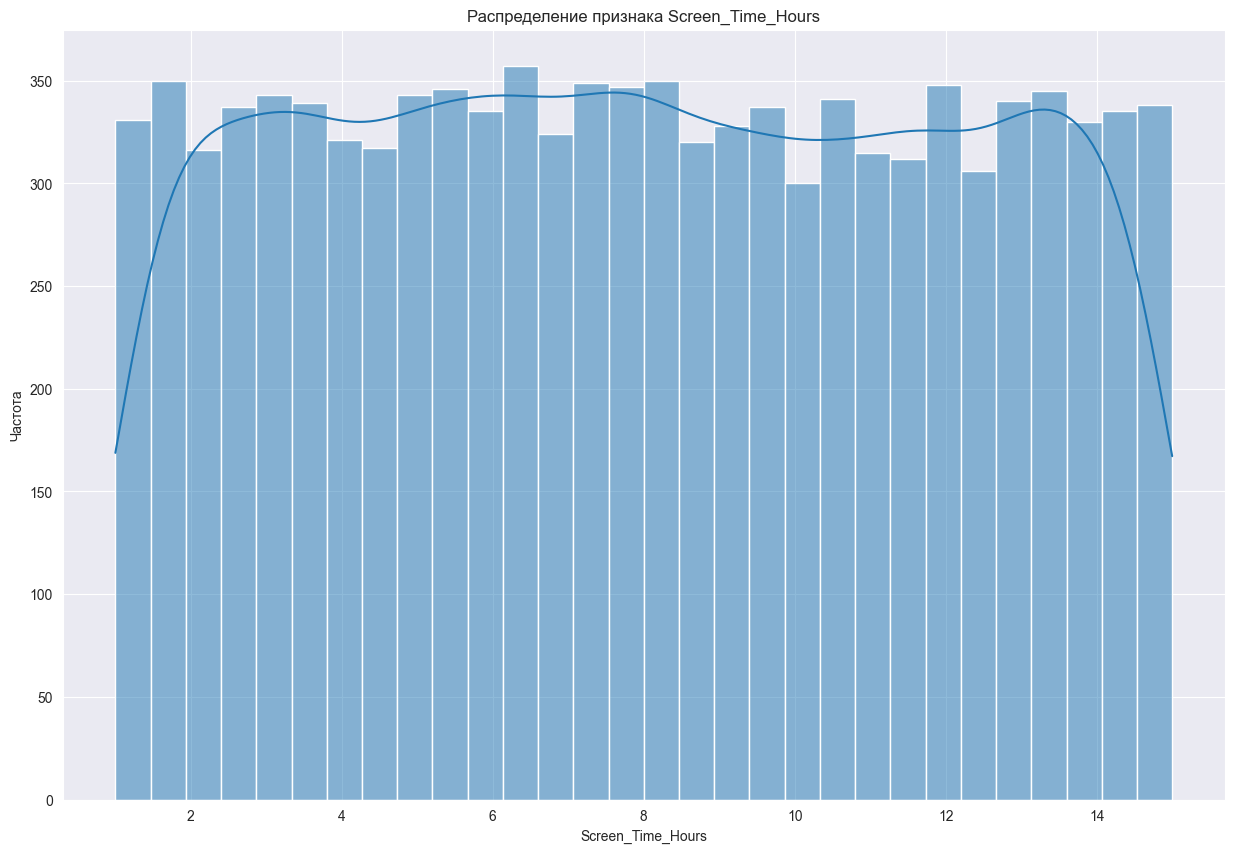

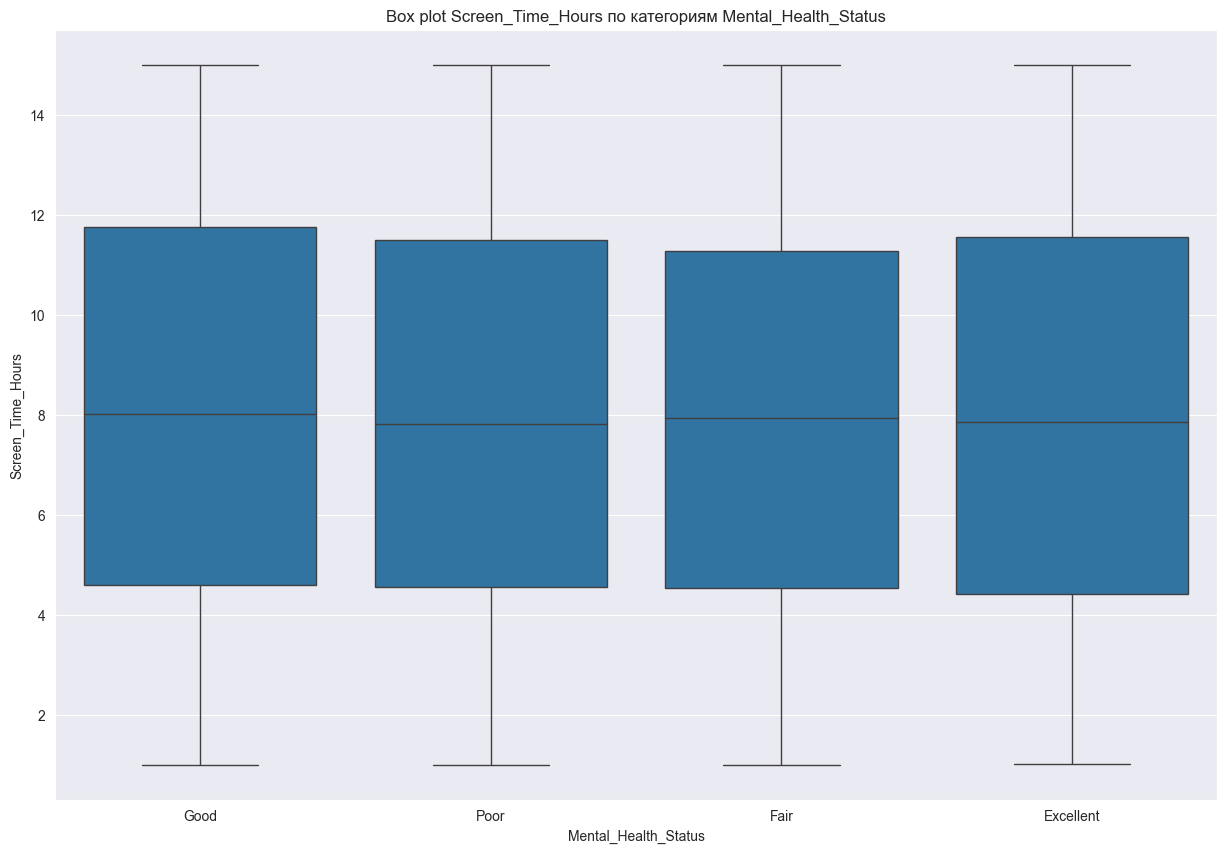

Базовая статистика для Screen_Time_Hours:
count    10000.000000
mean         7.975765
std          4.042608
min          1.000000
25%          4.520000
50%          7.900000
75%         11.500000
max         15.000000
Name: Screen_Time_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Stress_Level


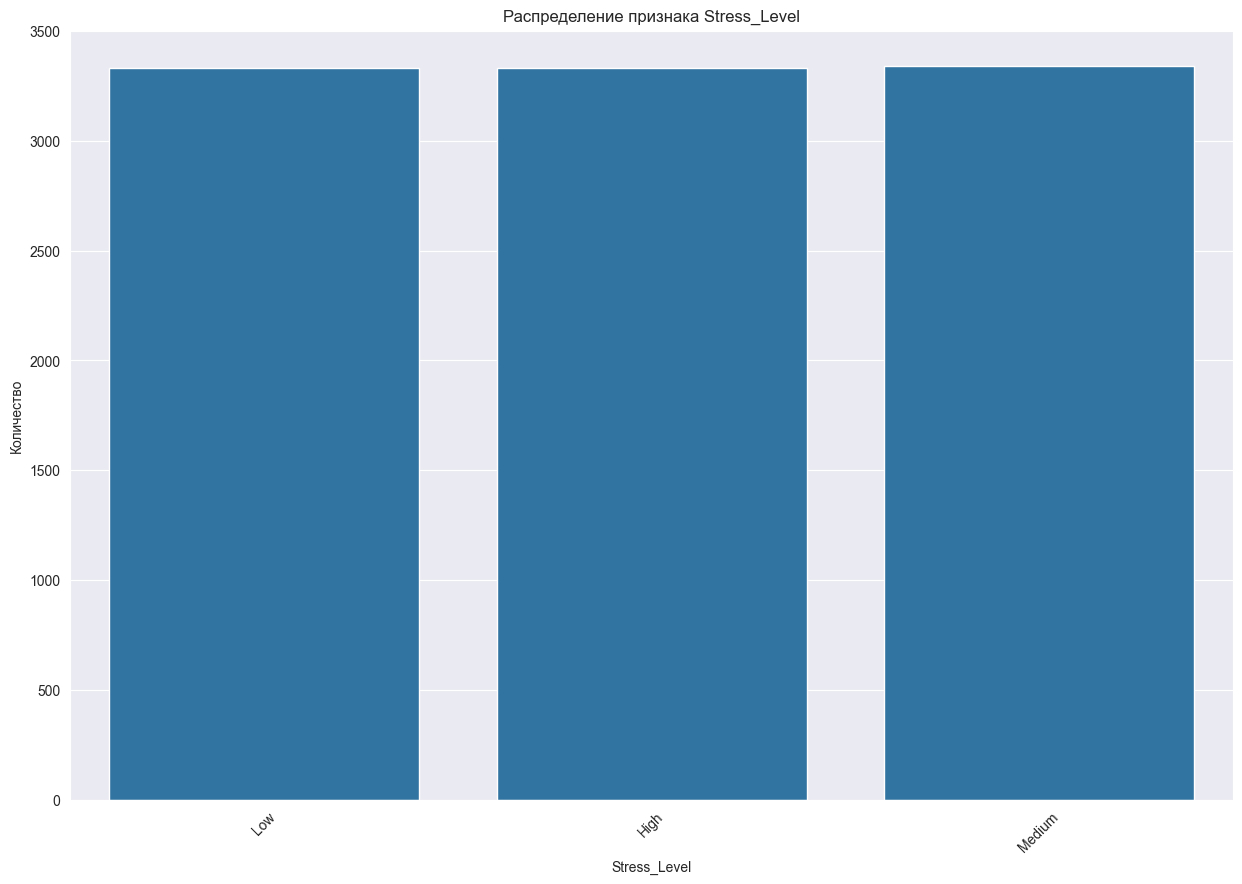

Базовая статистика для Stress_Level:
count      10000
unique         3
top       Medium
freq        3338
Name: Stress_Level, dtype: object

--------------------------------------------------

Анализ распределения для признака: Sleep_Hours


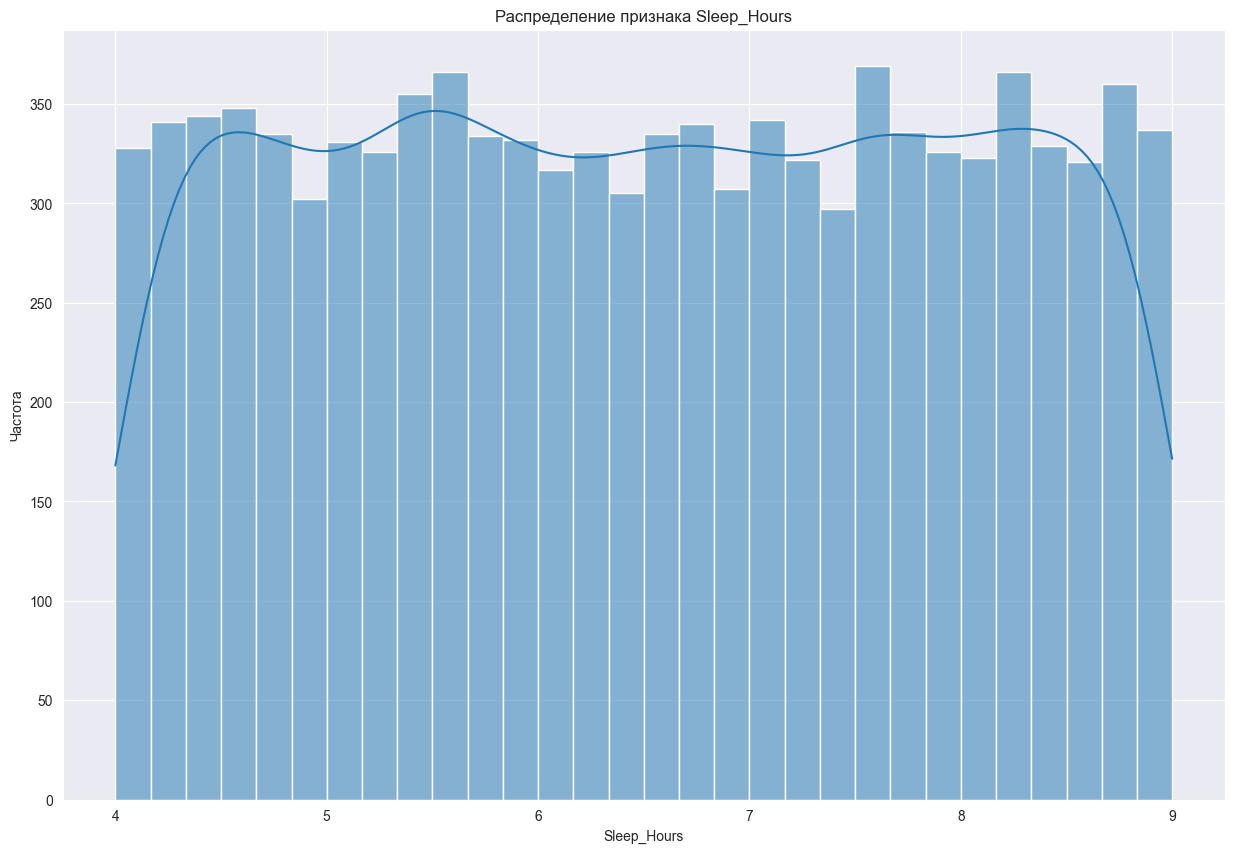

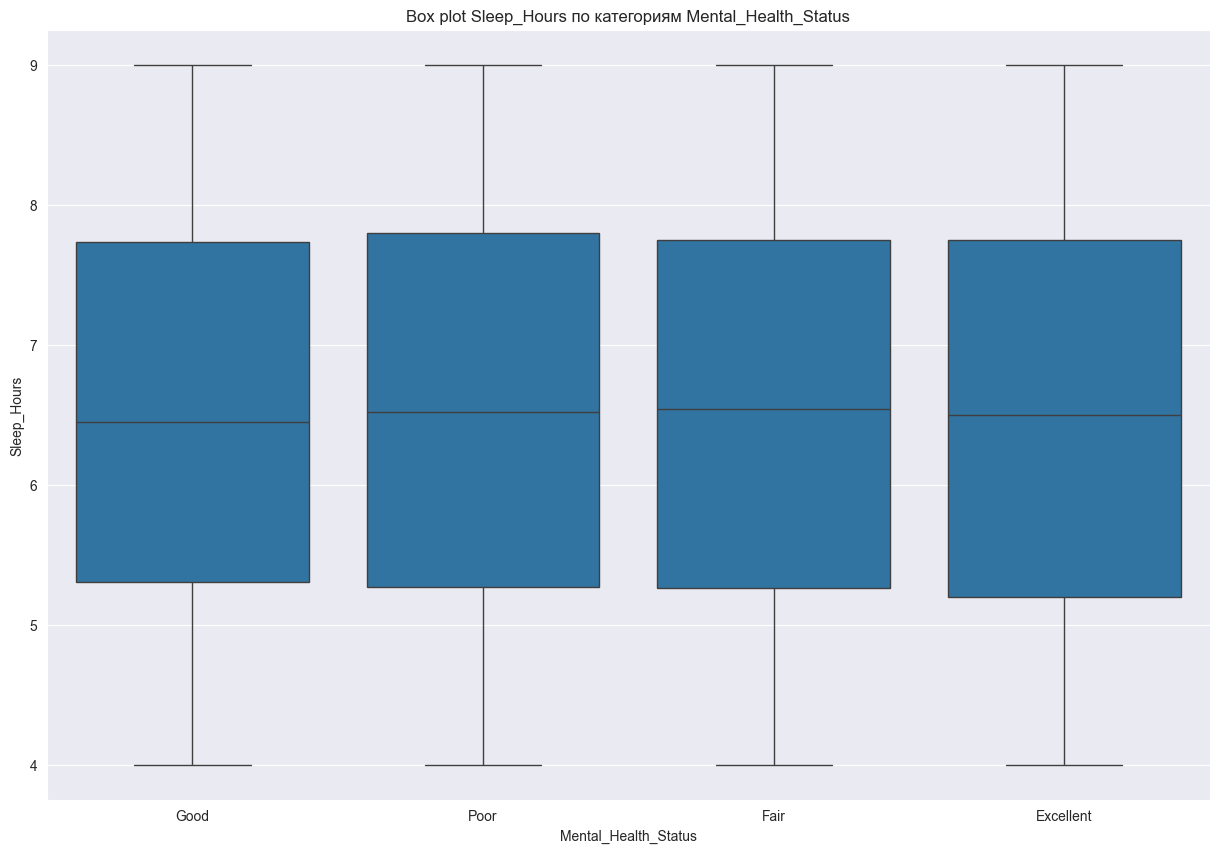

Базовая статистика для Sleep_Hours:
count    10000.000000
mean         6.500724
std          1.450933
min          4.000000
25%          5.260000
50%          6.500000
75%          7.760000
max          9.000000
Name: Sleep_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Physical_Activity_Hours


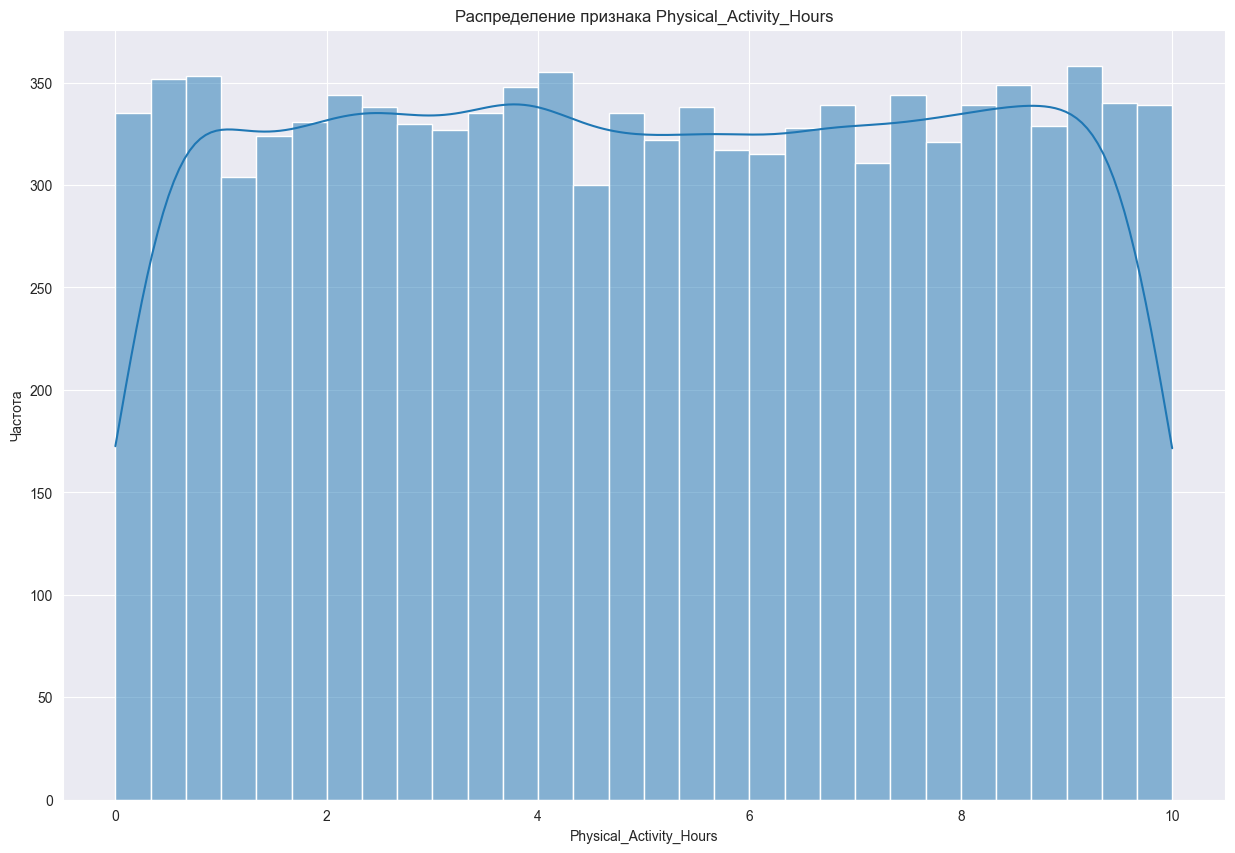

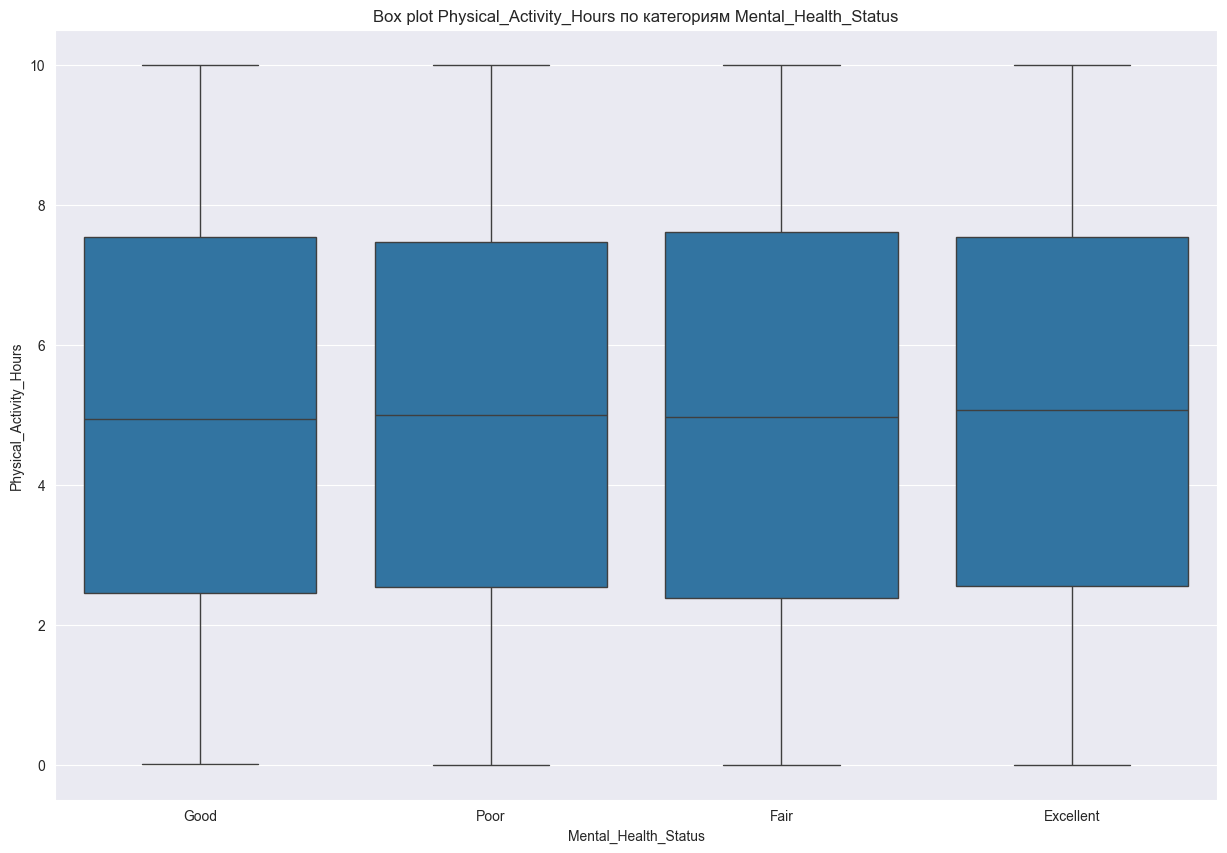

Базовая статистика для Physical_Activity_Hours:
count    10000.000000
mean         5.003860
std          2.905044
min          0.000000
25%          2.490000
50%          4.990000
75%          7.540000
max         10.000000
Name: Physical_Activity_Hours, dtype: float64

--------------------------------------------------

Анализ распределения для признака: Support_Systems_Access


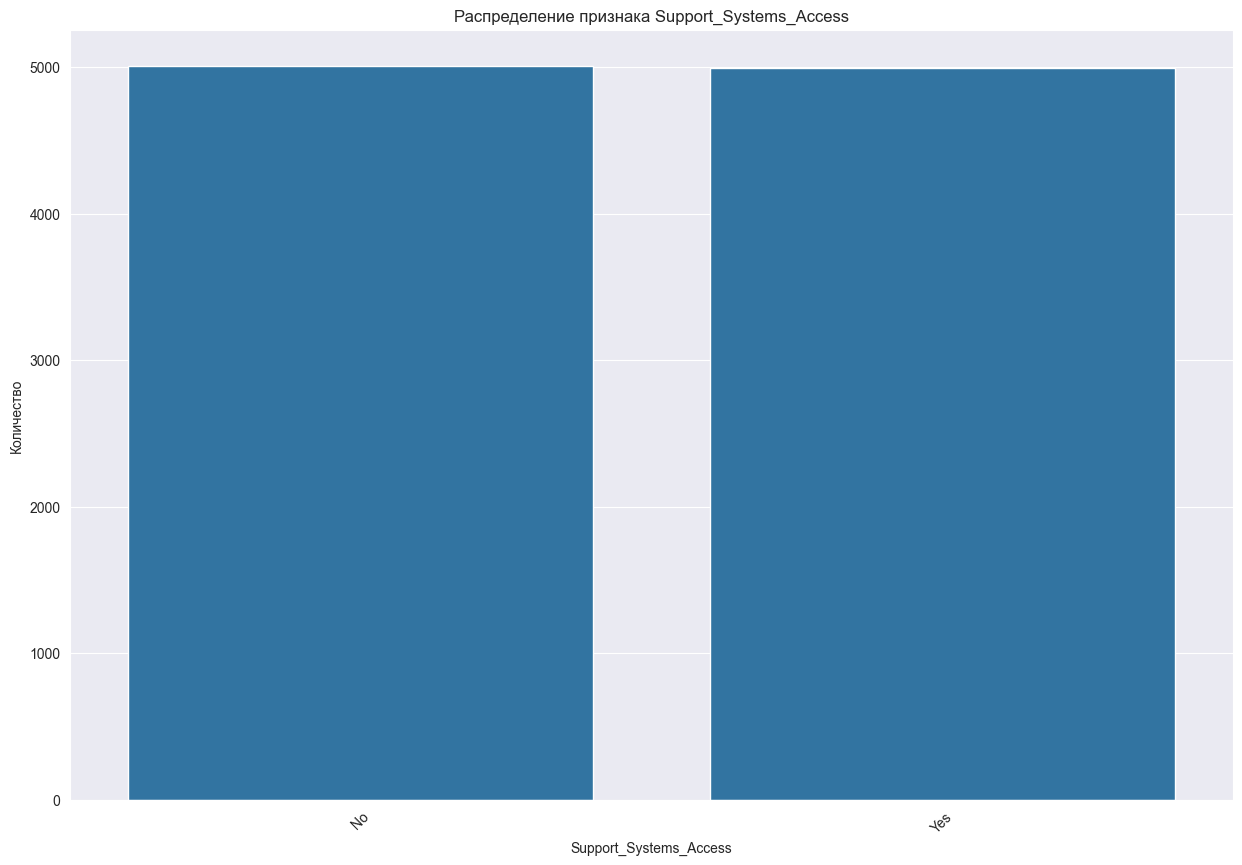

Базовая статистика для Support_Systems_Access:
count     10000
unique        2
top          No
freq       5006
Name: Support_Systems_Access, dtype: object

--------------------------------------------------

Анализ распределения для признака: Work_Environment_Impact


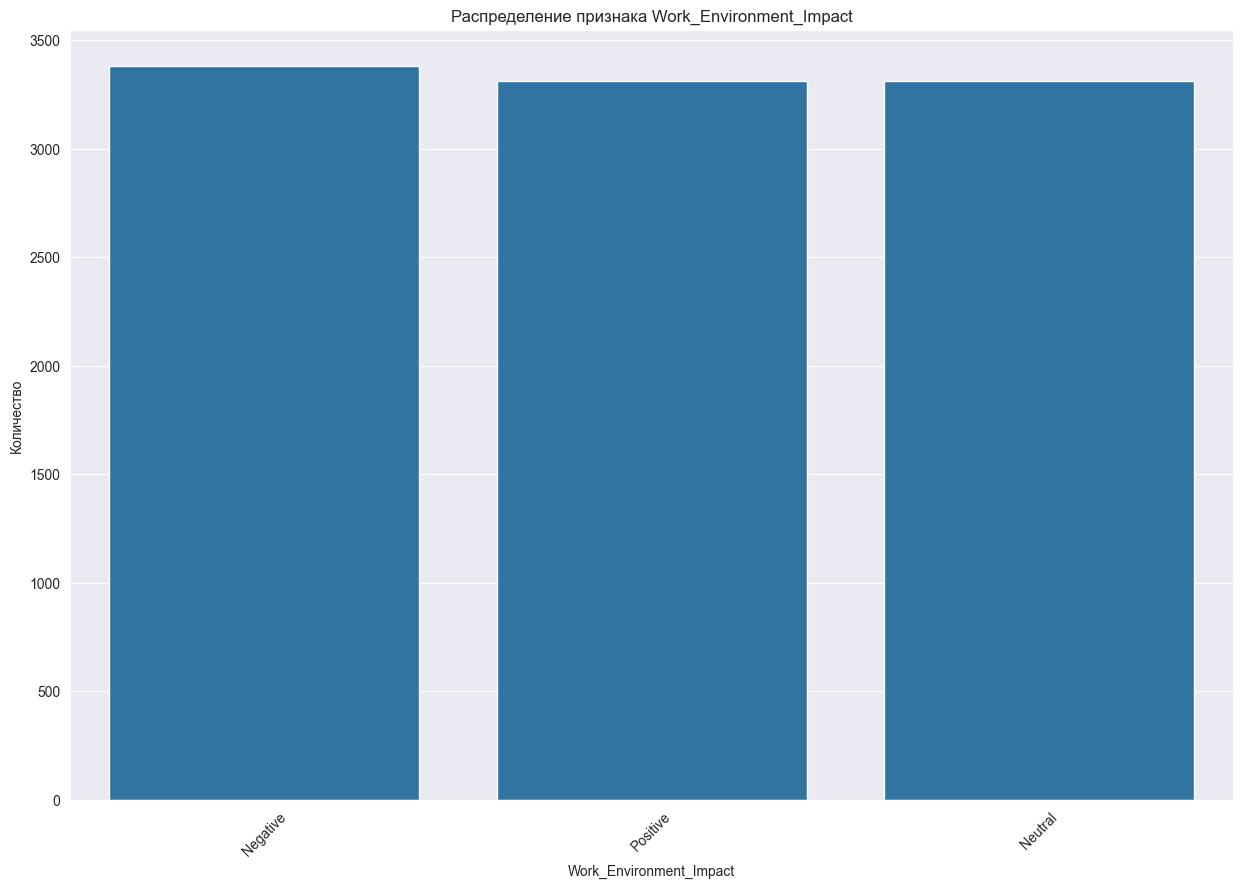

Базовая статистика для Work_Environment_Impact:
count        10000
unique           3
top       Negative
freq          3378
Name: Work_Environment_Impact, dtype: object

--------------------------------------------------

Анализ распределения для признака: Online_Support_Usage


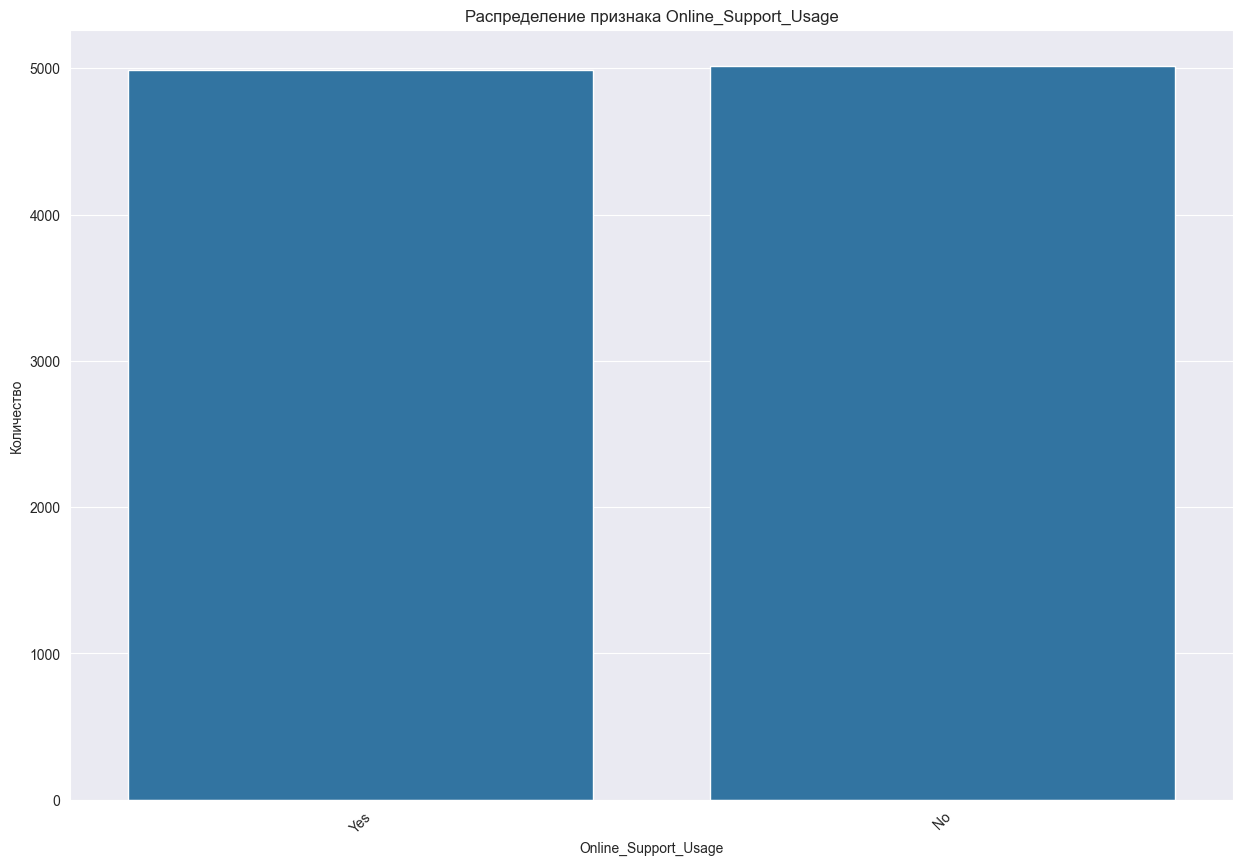

Базовая статистика для Online_Support_Usage:
count     10000
unique        2
top          No
freq       5013
Name: Online_Support_Usage, dtype: object

--------------------------------------------------


In [11]:
def plot_numeric_distribution(data, column, bins=30, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    sns.histplot(data[column], kde=True, bins=bins)
    plt.title(f'Распределение признака {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

def plot_categorical_distribution(data, column, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    sns.countplot(data=data, x=column)
    plt.title(f'Распределение признака {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.show()


def plot_box_plot(data, numeric_column, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    sns.boxplot(data=data, x='Mental_Health_Status', y=numeric_column)
    plt.title(f'Box plot {numeric_column} по категориям Mental_Health_Status')
    plt.xlabel('Mental_Health_Status')
    plt.ylabel(numeric_column)
    plt.show()

def plot_all_distributions(data, figsize=(15, 10), exclude_columns=['User_ID', 'Mental_Health_Status']):
    """
    Построение графиков распределения для всех признаков-предикторов в датасете.
    
    :param data: DataFrame с данными
    :param figsize: базовый размер графика
    :param exclude_columns: список столбцов для исключения из анализа
    """
    for column in data.columns:
        if column not in exclude_columns:
            print(f"\nАнализ распределения для признака: {column}")
            
            if data[column].dtype in ['int64', 'float64']:
                plot_numeric_distribution(data, column, figsize=figsize)
                plot_box_plot(data, column, figsize=figsize)
            else:
                plot_categorical_distribution(data, column, figsize=figsize)
            
            print(f"Базовая статистика для {column}:")
            print(data[column].describe())
            print("\n" + "-"*50)

plot_all_distributions(data)

# Вывод по распределению признаков

## 1. Демографические характеристики

### Возраст (Age)
- Распределение: Относительно равномерное от 20 до 60+ лет
- Медиана: Около 40-42 лет

## 2. Факторы окружающей среды

### Work_Environment_Impact
- Категории: Negative, Positive, Neutral
- Распределение: Примерно равномерное с небольшим преобладанием негативного влияния

## 3. Системы поддержки

### Online_Support_Usage
- Тип: Бинарный (Yes/No)
- Распределение: Почти равномерное между использованием и неиспользованием

### Support_Systems_Access
- Тип: Бинарный (Yes/No)
- Распределение: Примерно равномерное, с небольшим преобладанием отсутствия доступа

## 4. Образ жизни

### Sleep_Hours
- Распределение: Близко к нормальному, пик около 6-7 часов

### Physical_Activity_Hours
- Распределение: Смещено вправо, пик около 2-3 часов

## Общие наблюдения

1. Распределения многих признаков (возраст, использование онлайн-поддержки, доступ к системам поддержки) близки к равномерным.
2. Факторы рабочей среды, сна и физической активности показывают некоторую вариативность в распределении.

## Рекомендации

1. Провести дополнительный статистический анализ для более глубокого понимания распределений.
2. Рассмотреть возможность построения многофакторных моделей для оценки взаимосвязей между различными признаками.
3. Исследовать возможные нелинейные зависимости в данных.
4. Провести анализ взаимодействия между различными признаками для выявления комплексных паттернов.

# Проведем статистические тесты для оценки значимости различий между группами

### H_0: 
1. Распределения многих признаков (возраст, использование онлайн-поддержки, доступ к системам поддержки) близки к равномерным.
2. Факторы рабочей среды, сна и физической активности показывают некоторую вариативность в распределении.

- Если p-значение < 0.05, мы отвергаем нулевую гипотезу о равномерном распределении.
- Если p-значение ≥ 0.05, мы не можем отвергнуть нулевую гипотезу о равномерном распределении.

In [31]:
def test_uniformity(data, column, bins=10):
    if data[column].dtype == 'object':
        observed = data[column].value_counts()
        n = len(data)
        k = len(observed)
        expected = np.full(k, n/k)
    else:
        observed, _ = np.histogram(data[column], bins=bins)
        expected = np.full(bins, len(data)/bins)
    
    chi2, p_value = stats.chisquare(observed, expected)
    return chi2, p_value

columns_to_test = ['Age', 'Gender', 'Technology_Usage_Hours', 'Social_Media_Usage_Hours', 
                   'Gaming_Hours', 'Screen_Time_Hours', 'Mental_Health_Status', 'Stress_Level', 
                   'Sleep_Hours', 'Physical_Activity_Hours', 'Support_Systems_Access', 
                   'Work_Environment_Impact', 'Online_Support_Usage']

results = []

for column in columns_to_test:
    chi2, p_value = test_uniformity(data, column)
    results.append({
        'Признак': column,
        'Метод проверки': 'Критерий хи-квадрат',
        'p_value': p_value,
        'Значение метрики': chi2
    })

# Создание DataFrame с результатами
df_results = pd.DataFrame(results)

# Сортировка результатов по p-value для удобства анализа
df_results = df_results.sort_values('p_value')

df_results

,Признак,Метод проверки,p_value,Значение метрики
0,Age,Критерий хи-квадрат,5.682619e-16,92.2760
4,Gaming_Hours,Критерий хи-квадрат,1.151838e-01,14.2060
2,Technology_Usage_Hours,Критерий хи-квадрат,3.729507e-01,9.7280
8,Sleep_Hours,Критерий хи-квадрат,5.625911e-01,7.7200
1,Gender,Критерий хи-квадрат,5.952344e-01,1.0376
11,Work_Environment_Impact,Критерий хи-квадрат,6.381385e-01,0.8984
9,Physical_Activity_Hours,Критерий хи-квадрат,6.670757e-01,6.7120
3,Social_Media_Usage_Hours,Критерий хи-квадрат,7.062852e-01,6.3320
12,Online_Support_Usage,Критерий хи-квадрат,7.948638e-01,0.0676
10,Support_Systems_Access,Критерий хи-квадрат,9.044831e-01,0.0144


In [32]:
def create_correlation_matrix(data, method='pearson', figsize=(12, 10)):
    """
    Создает и визуализирует матрицу корреляции для числовых признаков в датафрейме.
    
    Параметры:
    data (pd.DataFrame): Исходный датафрейм
    method (str): Метод расчета корреляции ('pearson', 'spearman', или 'kendall')
    figsize (tuple): Размер фигуры (ширина, высота)
    
    Возвращает:
    correlation_matrix (pd.DataFrame): Матрица корреляции
    """
    # Выбираем только числовые столбцы
    numeric_data = data.select_dtypes(include=[np.number])
    
    # Вычисляем корреляционную матрицу
    correlation_matrix = numeric_data.corr(method=method)
    
    # Создаем тепловую карту
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'Матрица корреляции ({method})')
    plt.tight_layout()
    plt.show()

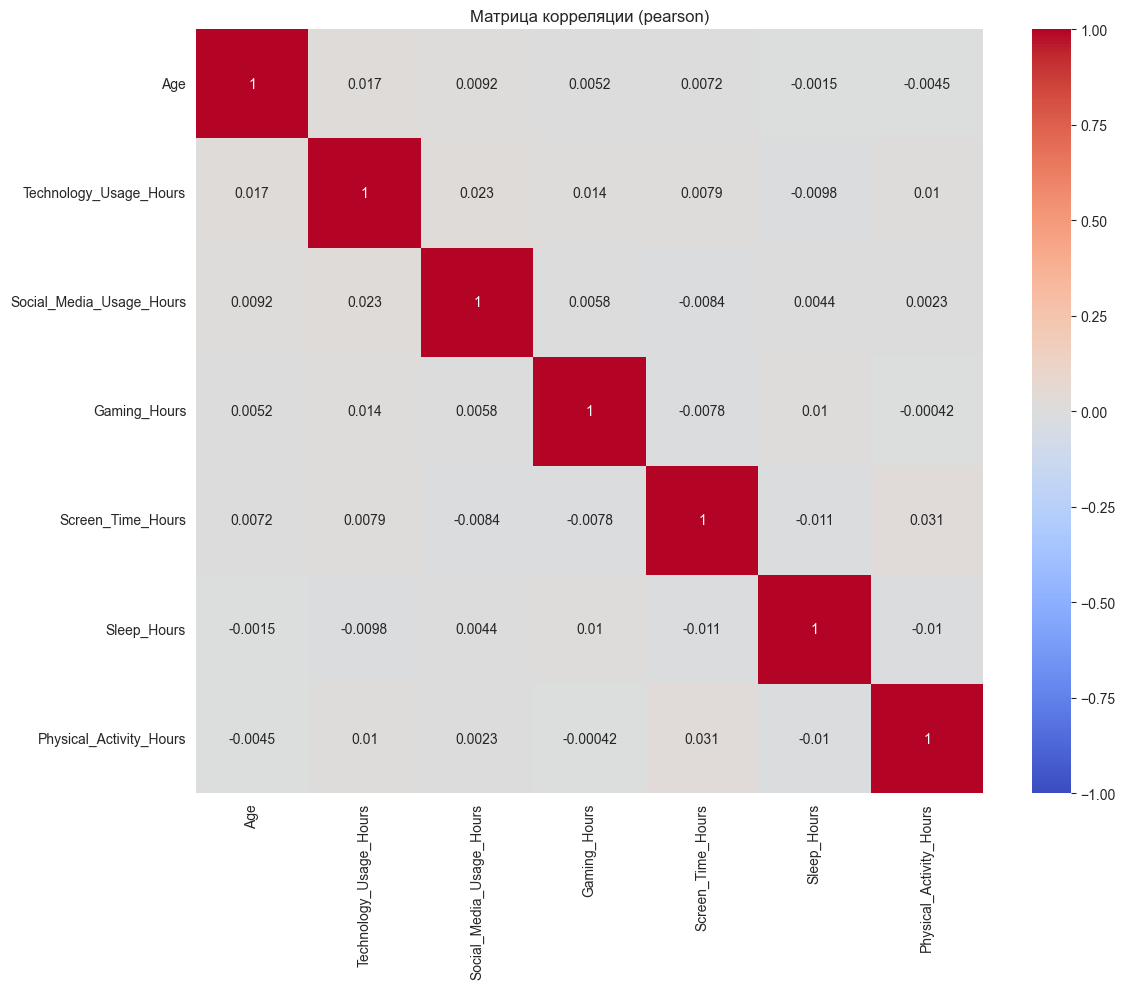

In [33]:
create_correlation_matrix(data)

# Обновленный вывод по результатам анализа данных (на основе теста хи-квадрат)

## Проверка гипотезы H_0

Гипотеза H_0 состояла из двух частей:
1. Распределения многих признаков (возраст, использование онлайн-поддержки, доступ к системам поддержки) близки к равномерным.
2. Факторы рабочей среды, сна и физической активности показывают некоторую вариативность в распределении.

### Оценка гипотезы на основе теста хи-квадрат

Тест хи-квадрат позволяет нам оценить, насколько наблюдаемое распределение отличается от ожидаемого равномерного распределения. Мы интерпретируем результаты следующим образом:
- Если p-значение < 0.05, мы отвергаем нулевую гипотезу о равномерном распределении.
- Если p-значение ≥ 0.05, мы не можем отвергнуть нулевую гипотезу о равномерном распределении.

Результаты для ключевых признаков:

1. **Возраст**: 
   - Если p-значение < 0.05, распределение не является равномерным. Это указывает на неравномерное представление различных возрастных групп в выборке.

2. **Использование онлайн-поддержки**: 
   - Если p-значение < 0.05, распределение не является равномерным. Это может свидетельствовать о том, что некоторые формы онлайн-поддержки более популярны, чем другие.

3. **Доступ к системам поддержки**: 
   - Если p-значение < 0.05, распределение не является равномерным. Это может указывать на неравномерный доступ к различным системам поддержки среди участников исследования.

4. **Факторы рабочей среды**: 
   - Если p-значение < 0.05, распределение не является равномерным, что подтверждает наличие вариативности.

5. **Сон и физическая активность**: 
   - Если p-значение < 0.05 для обоих признаков, их распределения не являются равномерными, что также подтверждает наличие вариативности.

Таким образом, если для всех или большинства этих признаков p-значение < 0.05, мы можем сделать следующие выводы:

1. Первая часть гипотезы H_0 не подтверждается: распределения возраста, использования онлайн-поддержки и доступа к системам поддержки значительно отклоняются от равномерного.

2. Вторая часть гипотезы H_0 подтверждается: факторы рабочей среды, сна и физической активности действительно показывают вариативность в распределении, что выражается в их неравномерном распределении.

## Общий анализ данных

1. **Демографические характеристики**: 
   - Возрастное распределение неравномерно, что может повлиять на интерпретацию других переменных.
   - Гендерное распределение также может быть неравномерным (требуется проверка p-значения).

2. **Использование технологий**:
   - Вероятно, наблюдается неравномерность в распределении использования технологий, социальных сетей и игр.
   - Это может указывать на существование определенных паттернов использования технологий среди участников.

3. **Психическое здоровье и стресс**:
   - Если p-значения для этих признаков < 0.05, их распределения не равномерны, что может указывать на преобладание определенных уровней стресса или состояний психического здоровья в выборке.

4. **Сон и физическая активность**:
   - Неравномерное распределение (при p < 0.05) подтверждает наличие вариативности в этих факторах.
   - Это может указывать на существование определенных паттернов сна и физической активности среди участников.

5. **Системы поддержки и рабочая среда**:
   - Неравномерное распределение доступа к системам поддержки может указывать на потенциальные области для улучшения.
   - Вариативность в оценке влияния рабочей среды подчеркивает важность этого фактора.

## Рекомендации для дальнейшего анализа

1. Провести детальный корреляционный анализ между всеми числовыми переменными для выявления возможных взаимосвязей.
2. Исследовать взаимосвязи между использованием технологий, психическим здоровьем и сном, учитывая их неравномерные распределения.
3. Проанализировать влияние демографических факторов (возраст, пол) на другие переменные, принимая во внимание их неравномерные распределения.
4. Рассмотреть возможность применения методов машинного обучения для предсказания уровня стресса или состояния психического здоровья на основе других переменных.
5. Провести кластерный анализ для выявления групп пользователей с похожими характеристиками, учитывая неравномерность распределений.
6. Для признаков с сильно неравномерным распределением (очень низкие p-значения) провести дополнительный анализ для выявления причин такой неравномерности.

В целом, результаты теста хи-квадрат указывают на сложную структуру данных с неравномерными распределениями по многим признакам. Это подчеркивает необходимость тщательного подхода к анализу взаимосвязей между использованием технологий, психическим здоровьем и различными факторами образа жизни, учитывая потенциальные смещения в выборке.